In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
class DNN(nn.Module):
    """
    A simple fully-connected network that maps (x, y, t) -> (A_r, A_i).
    """
    def __init__(self, layers):
        super(DNN, self).__init__()

        self.linears = nn.ModuleList()
        for i in range(len(layers) - 1):
            self.linears.append(nn.Linear(layers[i], layers[i+1]))

        self.activation = nn.Tanh()  # can choose ReLU, Sigmoid, etc.

    def forward(self, x):
        # x shape: (batch, layers[0]) i.e. (batch, 3) if we do (x,y,t)
        for i in range(len(self.linears) - 1):
            x = self.linears[i](x)
            x = self.activation(x)
        x = self.linears[-1](x)   # final layer (no activation)
        return x

In [3]:
class CGLEPINN(nn.Module):
    """
    Physics-Informed Neural Network for the Complex Ginzburg-Landau (CGL) equation.
    """
    def __init__(
        self,
        layers,
        delta=1.0,             # fix delta, or treat it as a Parameter if you want
        mu_init=1.0,           # initial guess for mu
        weight_pde=1.0,        # weight for PDE residual
        device='cpu'
    ):
        super(CGLEPINN, self).__init__()

        # The neural net that maps (x, y, t) -> (A_r, A_i)
        self.dnn = DNN(layers).to(device)

        # We store a trainable log(mu) or direct mu. Let's do direct:
        self.mu = nn.Parameter(torch.tensor([mu_init], dtype=torch.float, device=device))

        # Keep delta as a normal float. (Or also a Parameter if you want to learn it.)
        self.delta = delta

        # PDE/data weighting
        self.weight_pde = weight_pde

        # We'll define an optimizer later in the "train_model" method
        # so we can incorporate both the net's parameters and mu in the same step.

        self.device = device

    def net_A(self, x, y, t):
        """
        Forward pass: returns real & imag parts of A.
        x, y, t should be Tensors of shape (batch,1).
        """
        # stack them: shape (batch, 3)
        inp = torch.cat([x, y, t], dim=1)
        out = self.dnn(inp)  # shape (batch, 2)

        A_r = out[:, 0:1]
        A_i = out[:, 1:2]
        return A_r, A_i

    def pde_residual(self, x, y, t):
        """
        Compute PDE residual (f_r, f_i) for the real and imaginary parts of:
           A_t - mu*A - delta Lap(A) + |A|^2 A = 0
        We'll do autograd to get partial derivatives wrt x, y, t.
        """
        mu_val = self.mu   # a scalar
        delta_val = self.delta

        # Get A from net
        A_r, A_i = self.net_A(x, y, t)

        # Time derivative:
        A_r_t = torch.autograd.grad(
            A_r, t,
            grad_outputs=torch.ones_like(A_r),
            create_graph=True, retain_graph=True
        )[0]
        A_i_t = torch.autograd.grad(
            A_i, t,
            grad_outputs=torch.ones_like(A_i),
            create_graph=True, retain_graph=True
        )[0]

        # First derivatives wrt x
        A_r_x = torch.autograd.grad(
            A_r, x,
            grad_outputs=torch.ones_like(A_r),
            create_graph=True, retain_graph=True
        )[0]
        A_i_x = torch.autograd.grad(
            A_i, x,
            grad_outputs=torch.ones_like(A_i),
            create_graph=True, retain_graph=True
        )[0]

        # First derivatives wrt y
        A_r_y = torch.autograd.grad(
            A_r, y,
            grad_outputs=torch.ones_like(A_r),
            create_graph=True, retain_graph=True
        )[0]
        A_i_y = torch.autograd.grad(
            A_i, y,
            grad_outputs=torch.ones_like(A_i),
            create_graph=True, retain_graph=True
        )[0]

        # Second derivatives
        A_r_xx = torch.autograd.grad(
            A_r_x, x,
            grad_outputs=torch.ones_like(A_r_x),
            create_graph=True, retain_graph=True
        )[0]
        A_r_yy = torch.autograd.grad(
            A_r_y, y,
            grad_outputs=torch.ones_like(A_r_y),
            create_graph=True, retain_graph=True
        )[0]

        A_i_xx = torch.autograd.grad(
            A_i_x, x,
            grad_outputs=torch.ones_like(A_i_x),
            create_graph=True, retain_graph=True
        )[0]
        A_i_yy = torch.autograd.grad(
            A_i_y, y,
            grad_outputs=torch.ones_like(A_i_y),
            create_graph=True, retain_graph=True
        )[0]

        # Laplacians
        lapA_r = A_r_xx + A_r_yy
        lapA_i = A_i_xx + A_i_yy

        # |A|^2 = A_r^2 + A_i^2
        A_abs2 = A_r**2 + A_i**2

        # PDE: A_t - mu*A - delta Lap(A) + |A|^2 A = 0
        # Separate real & imag parts:
        # Real part residual:
        f_r = A_r_t - mu_val*A_r - delta_val*lapA_r + A_abs2*A_r
        # Imag part residual:
        f_i = A_i_t - mu_val*A_i - delta_val*lapA_i + A_abs2*A_i

        return f_r, f_i

    def loss_pde(self, x_eqs, y_eqs, t_eqs):
        """
        Compute PDE loss = MSE of PDE residual at collocation points.
        """
        f_r, f_i = self.pde_residual(x_eqs, y_eqs, t_eqs)
        loss = torch.mean(f_r**2 + f_i**2)
        return loss

    def loss_data(self, x_data, y_data, t_data, A_r_data, A_i_data):
        """
        Data loss = MSE between predicted A_r, A_i and the measured data.
        """
        A_r_pred, A_i_pred = self.net_A(x_data, y_data, t_data)
        loss = torch.mean((A_r_pred - A_r_data)**2 + (A_i_pred - A_i_data)**2)
        return loss

    def forward(self, x, y, t):
        """
        A convenience if you just do: model(x,y,t).
        This returns A_r, A_i for quick usage.
        """
        return self.net_A(x, y, t)

    def train_model(self,
                    x_data, y_data, t_data, A_r_data, A_i_data,
                    x_eqs, y_eqs, t_eqs,
                    n_epochs=5000,
                    lr=1e-3):
        """
        Train the PINN with Adam (or LBFGS, etc.) on:
          total_loss = data_loss + weight_pde * pde_loss
        """

        # Create an optimizer that sees both the NN weights & mu
        optimizer = optim.Adam(self.parameters(), lr=lr)

        for epoch in range(n_epochs):
            optimizer.zero_grad()

            # PDE loss
            l_pde = self.loss_pde(x_eqs, y_eqs, t_eqs)

            # Data loss
            l_data = self.loss_data(x_data, y_data, t_data, A_r_data, A_i_data)

            # Weighted sum
            loss = l_data + self.weight_pde * l_pde

            loss.backward()
            optimizer.step()

            # Print progress occasionally
            if epoch % 500 == 0:
                print(f"Epoch {epoch}: loss={loss.item():.4e}, data={l_data.item():.4e}, "
                      f"pde={l_pde.item():.4e}, mu={self.mu.item():.5f}")

        print("Training complete.")

    def predict(self, x_star, y_star, t_star):
        """
        Evaluate the neural net at new points -> (A_r, A_i).
        Returns numpy arrays.
        """
        self.eval()  # put in eval mode
        with torch.no_grad():
            A_r, A_i = self.net_A(x_star, y_star, t_star)
        return A_r.detach().cpu().numpy(), A_i.detach().cpu().numpy()


In [4]:
from src.simulation.simulation import *

In [5]:
number_of_frames    = 250
discretization_size = 290
d                   = (0.1, 0.3, 0.3)
N                   = (number_of_frames, discretization_size, discretization_size)
myu_size            = (50, 10, 10)
myu_mstd            = (5.4, 0.6)

sim = Simulation(
    d=d,
    N=N,
    myu_size=myu_size,
    myu_mstd=myu_mstd
)

state, myu = sim.compute()

Computing States: 100%|██████████| 249/249 [00:03<00:00, 77.12it/s]


In [18]:
state.shape, myu.shape

((250, 290, 290), (250, 290, 290))

In [17]:
A_r_data = state.real  # shape (Nt, Nx, Ny)
A_i_data = state.imag  # shape (Nt, Nx, Ny)

In [19]:
Nt, Nx, Ny = N  # So Nt=250, Nx=290, Ny=290

In [20]:
t_vals = np.arange(0, Nt) * 0.1      # shape (250,)
x_vals = np.arange(0, Nx) * 0.3      # shape (290,)
y_vals = np.arange(0, Ny) * 0.3      # shape (290,)

In [21]:
n_data = 20000

# Randomly pick time indices
idx_t = np.random.randint(0, Nt, size=n_data)
idx_x = np.random.randint(0, Nx, size=n_data)
idx_y = np.random.randint(0, Ny, size=n_data)

# Convert to physical coords
t_data_np = t_vals[idx_t]
x_data_np = x_vals[idx_x]
y_data_np = y_vals[idx_y]

# Ground-truth real, imag
Ar_data_np = A_r_data[idx_t, idx_x, idx_y]
Ai_data_np = A_i_data[idx_t, idx_x, idx_y]

In [22]:
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'

x_data_t = torch.tensor(x_data_np, dtype=torch.float32).view(-1,1).to(device)
y_data_t = torch.tensor(y_data_np, dtype=torch.float32).view(-1,1).to(device)
t_data_t = torch.tensor(t_data_np, dtype=torch.float32).view(-1,1).to(device)

Ar_data_t = torch.tensor(Ar_data_np, dtype=torch.float32).view(-1,1).to(device)
Ai_data_t = torch.tensor(Ai_data_np, dtype=torch.float32).view(-1,1).to(device)

In [26]:
n_coll = 20000
t_eqs_np = np.random.uniform(0, t_vals[-1], size=n_coll)
x_eqs_np = np.random.uniform(0, x_vals[-1], size=n_coll)
y_eqs_np = np.random.uniform(0, y_vals[-1], size=n_coll)

# Convert to Tensors
x_eqs_t = torch.tensor(x_eqs_np, dtype=torch.float32, device=device, requires_grad=True).view(-1,1)
y_eqs_t = torch.tensor(y_eqs_np, dtype=torch.float32, device=device, requires_grad=True).view(-1,1)
t_eqs_t = torch.tensor(t_eqs_np, dtype=torch.float32, device=device, requires_grad=True).view(-1,1)

In [44]:
model = CGLEPINN(
    layers=[3, 64, 64, 64, 64, 2],
    delta=0.01,      # or the same delta from your sim if it's fixed
    mu_init=5.0,     # a guess
    weight_pde=0.1,  # balance PDE vs. data
    device=device
).to(device)

In [49]:
model.train_model(
    x_data_t, y_data_t, t_data_t,
    Ar_data_t, Ai_data_t,            # data mismatch
    x_eqs_t, y_eqs_t, t_eqs_t,       # PDE residual
    n_epochs=5000,   # or more
    lr=1e-3
)

Epoch 0: loss=3.9013e+00, data=3.5097e+00, pde=3.9157e+00, mu=4.35267
Epoch 500: loss=3.6149e+00, data=3.2692e+00, pde=3.4578e+00, mu=3.88988


KeyboardInterrupt: 

In [29]:
torch.backends.cudnn.benchmark = True

In [32]:
model.mu

Parameter containing:
tensor([2.7975], device='cuda:0', requires_grad=True)

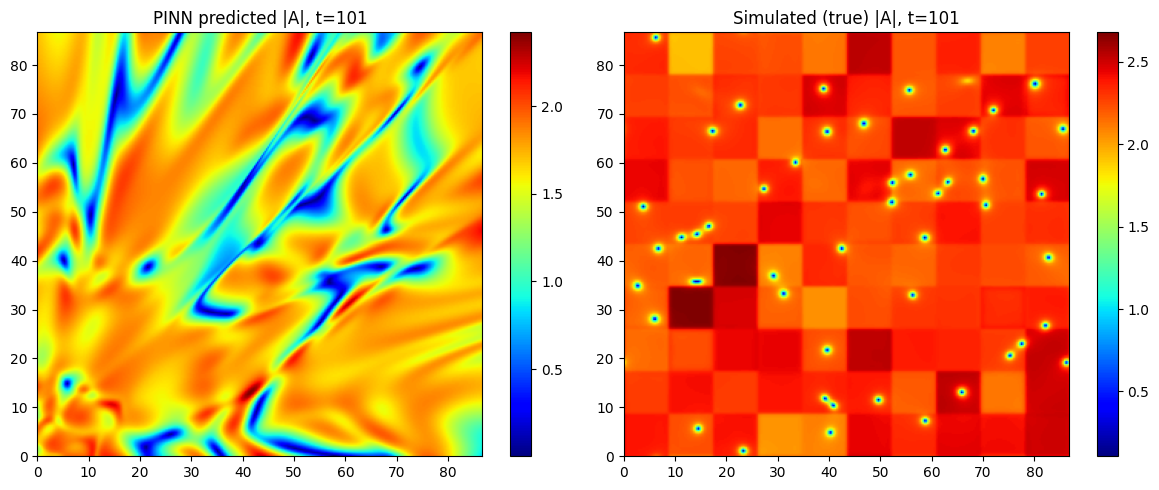

In [42]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# --- 1) Extract real & imag from your simulation data
A_r_data = state.real  # shape (250, 290, 290)
A_i_data = state.imag  # shape (250, 290, 290)

# If you haven't defined these yet, do so:
Nt, Nx, Ny = state.shape  # (250, 290, 290)
dt, dx, dy = d            # (0.1, 0.3, 0.3)

t_vals = np.arange(Nt) * dt  # shape (250,)
x_vals = np.arange(Nx) * dx  # shape (290,)
y_vals = np.arange(Ny) * dy  # shape (290,)

# --- 2) Choose a time index
i = 101
t_test_val = t_vals[i]  # float, e.g. 10.0 if dt=0.1 and i=100

# --- 3) Make a fine (X,Y) grid for PINN evaluation
x_grid = np.linspace(0, x_vals[-1], 300)  # 300 points from 0..(290*0.3=87)
y_grid = np.linspace(0, y_vals[-1], 300)  # same in y
XX, YY = np.meshgrid(x_grid, y_grid)

# For the time coordinate, fill with t_test_val
TT = np.full_like(XX, t_test_val)

# Convert to PyTorch Tensors on the correct device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
x_test_t = torch.tensor(XX.ravel(), dtype=torch.float32).view(-1,1).to(device)
y_test_t = torch.tensor(YY.ravel(), dtype=torch.float32).view(-1,1).to(device)
t_test_t = torch.tensor(TT.ravel(), dtype=torch.float32).view(-1,1).to(device)

# --- 4) Use the PINN to predict real, imag parts on this grid
A_r_pred, A_i_pred = model.predict(x_test_t, y_test_t, t_test_t)
Ar_2d = A_r_pred.reshape(XX.shape)
Ai_2d = A_i_pred.reshape(XX.shape)
absA_2d = np.sqrt(Ar_2d**2 + Ai_2d**2)

# --- 5) Get the "true" simulated field at the same time index i=100
#        shape is (Nx, Ny) = (290, 290)
Ar_true_2d = A_r_data[i]    # real part
Ai_true_2d = A_i_data[i]    # imag part
absA_true_2d = np.sqrt(Ar_true_2d**2 + Ai_true_2d**2)

# --- 6) Plot side-by-side
fig, ax = plt.subplots(1, 2, figsize=(12,5))

c1 = ax[0].imshow(absA_2d, origin='lower',
                  extent=[0, x_vals[-1], 0, y_vals[-1]],
                  aspect='auto', cmap='jet')
ax[0].set_title(f"PINN predicted |A|, t={i}")
plt.colorbar(c1, ax=ax[0])

c2 = ax[1].imshow(absA_true_2d, origin='lower',
                  extent=[0, x_vals[-1], 0, y_vals[-1]],
                  aspect='auto', cmap='jet')
ax[1].set_title(f"Simulated (true) |A|, t={i}")
plt.colorbar(c2, ax=ax[1])

plt.tight_layout()
plt.show()

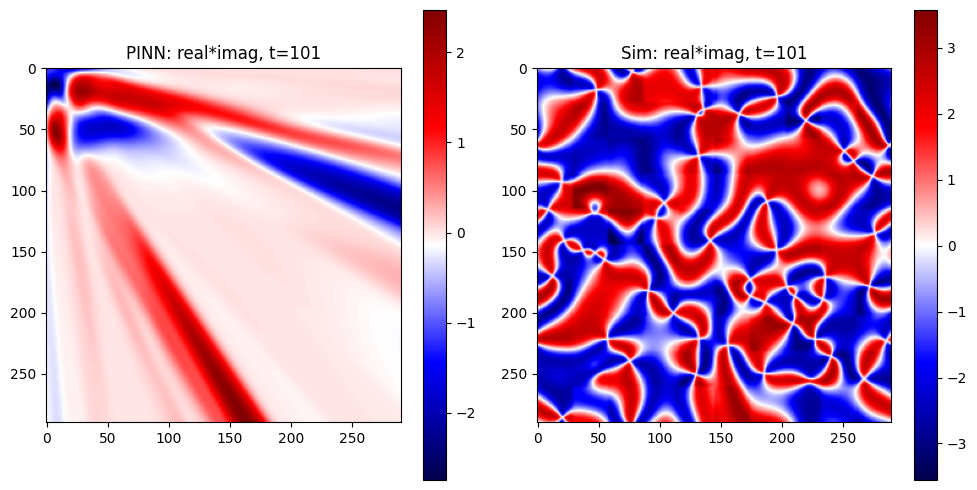

In [48]:
i = 101
# 1) PINN on a (290,290) grid, just to match the simulation's grid indices
X, Y = np.meshgrid(x_vals, y_vals)      # shape = (290,290) each
XX = X.ravel()
YY = Y.ravel()
TT = np.full_like(XX, t_vals[i])        # fill with time i => t_test_val

x_test_t = torch.tensor(XX, dtype=torch.float32).view(-1,1).to(device)
y_test_t = torch.tensor(YY, dtype=torch.float32).view(-1,1).to(device)
t_test_t = torch.tensor(TT, dtype=torch.float32).view(-1,1).to(device)

A_r_pred, A_i_pred = model.predict(x_test_t, y_test_t, t_test_t)
A_r_pred_2d = A_r_pred.reshape(290, 290)
A_i_pred_2d = A_i_pred.reshape(290, 290)

# 2) Real×Imag for PINN
pinn_prod = A_r_pred_2d * A_i_pred_2d

# 3) Real×Imag for Simulation
sim_prod = state[ i ].real * state[ i ].imag

# 4) Plot side by side
fig, ax = plt.subplots(1,2, figsize=(10,5))
img1 = ax[0].imshow(pinn_prod, cmap='seismic')
ax[0].set_title("PINN: real*imag, t=101")
plt.colorbar(img1, ax=ax[0])

img2 = ax[1].imshow(sim_prod, cmap='seismic')
ax[1].set_title("Sim: real*imag, t=101")
plt.colorbar(img2, ax=ax[1])

plt.tight_layout()
plt.show()

In [50]:
model.mu

Parameter containing:
tensor([3.7924], device='cuda:0', requires_grad=True)